# Support Vector Machine Linear classifier 

Here we implement a linear classified for CIFAR-10 dataset http://www.cs.toronto.edu/~kriz/cifar.html
Since it's a simple linear modelwe try to implement is ourself without relying on well-developed libraries like `PyTorch` or `TensorFlow`. 

In [170]:
# standart inputs
import matplotlib.pyplot as plt
import numpy as np

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Here we get the dataset
We download and extract the CIFAR-10 dataset.
No need to understand the following code.

In [47]:
import os
import requests
import tarfile

dataset_url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
dataset_folder = "cifar-10"

if not os.path.exists(dataset_folder):
    filename = os.path.basename(dataset_url)
    # here we load the dataset from the url
    with open(filename, "wb") as f:
        with requests.get(dataset_url, allow_redirects=True, stream=True) as response:
            total_length = response.headers.get('content-length')
            if total_length is None: # no content length header
                f.write(response.content)
            else:
                dl = 0
                total_length = int(total_length)
                for data in response.iter_content(chunk_size=4*4096):
                    dl += len(data)
                    f.write(data)
                    done = int(50 * dl / total_length)
                    sys.stdout.write("\r Download in progress: [%s%d%%%s]" % ('/' * done, done*2,' ' * (50-done)) )    
                    sys.stdout.flush()
        
    # here we 'untar' it
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()#path=dataset_folder+'/.')
    os.rename(tar.getnames()[0], dataset_folder)
    tar.close()
    
    #here we delete the .tarball
    os.remove(filename)

 Download in progress: [//////////////////////////////////////////////////100%]

## Loading the data
So far no need to understand the following, but keep in mind that sometimes loading the data also take some effort. And this case is far from worst scenarios.

In [186]:
# The data is split in 6 batches (including the testing one). We merge them all together.

dataset = {}
for batch in range(6):
    if batch != 5:
        filename = 'data_batch_%d' %(batch+1)
    else:
        filename = 'test_batch'
    ds_batch = np.load('%s/%s' %(dataset_folder, filename),
                       allow_pickle=True, encoding='latin1')

    for key in ['labels', 'data']:
        if key not in dataset:
            dataset[key] = ds_batch[key]
            dataset[key] = np.array(dataset[key])
        else:
            dataset[key] = np.concatenate((dataset[key], np.array(ds_batch[key])))

dataset['data'] = dataset['data'].reshape(dataset['data'].shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float")
# normalize to 1
dataset['data'] /= 255.

In [187]:
dataset['labels'].shape, dataset['data'].shape

((60000,), (60000, 32, 32, 3))

In [188]:
# the labels are stored in numeric format
# we can use this dictionary to decode the labels

labels = {
    0: 'airplane',
    1: 'auto',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

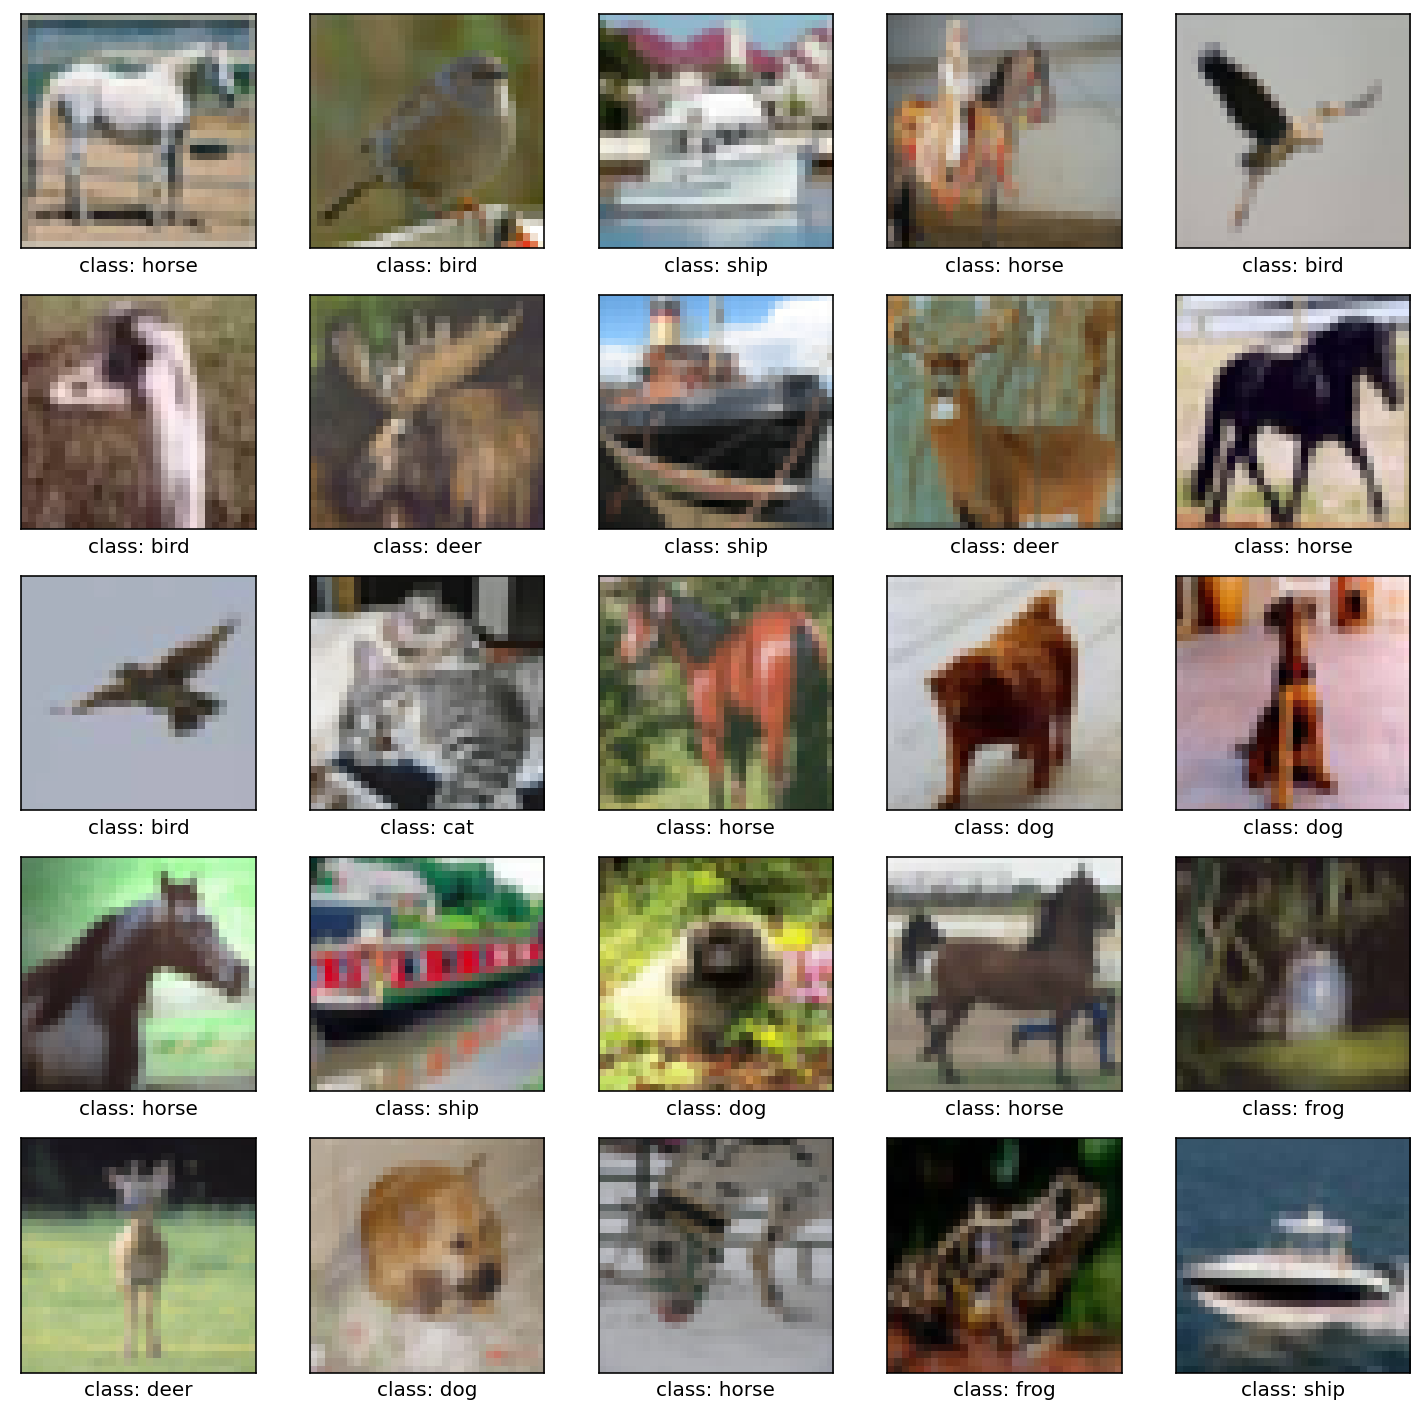

In [191]:
def plot_random_images(ds, n_images):
    # guess the size of the grid    
    size = np.sqrt(n_images)
    if size**2 != n_images:
        size += 1
    size = int(size)
    
    #initiate the figure size
    plt.figure(figsize=(2.5*size,2.5*size))
    
    # plot the images 
    for i in range(n_images):
        plt.subplot(size, size, i+1)
        
        # get a random image        
        rand_ind = np.random.randint(0,len(ds['labels']))
        
        plt.imshow(ds['data'][rand_ind])
        label_ind = ds['labels'][rand_ind]
        label = labels[label_ind]
        xlabel = "class: {0}".format(label)
        
        # show the classes as the label on the x-axis.
        plt.xlabel(xlabel)
    
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    return

plot_random_images(dataset, 25)

In [192]:
# split the dataset into training and testing
def split_data(data, test_ratio):
    data_len = len(data['data'])
    shuffled_indices = np.random.permutation(data_len)
    test_set_size = int(data_len * test_ratio)
    
    # use proper amount of elements
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    data_train = {}
    data_test = {}
    for key in data:
        data_train[key] = data[key][train_indices]
        data_test[key] = data[key][test_indices]
    return data_train, data_test

# here we use 1/10 of data for testing 
train, test = split_data(dataset, 0.1)

In [193]:
train['data'].shape, test['data'].shape

((54000, 32, 32, 3), (6000, 32, 32, 3))

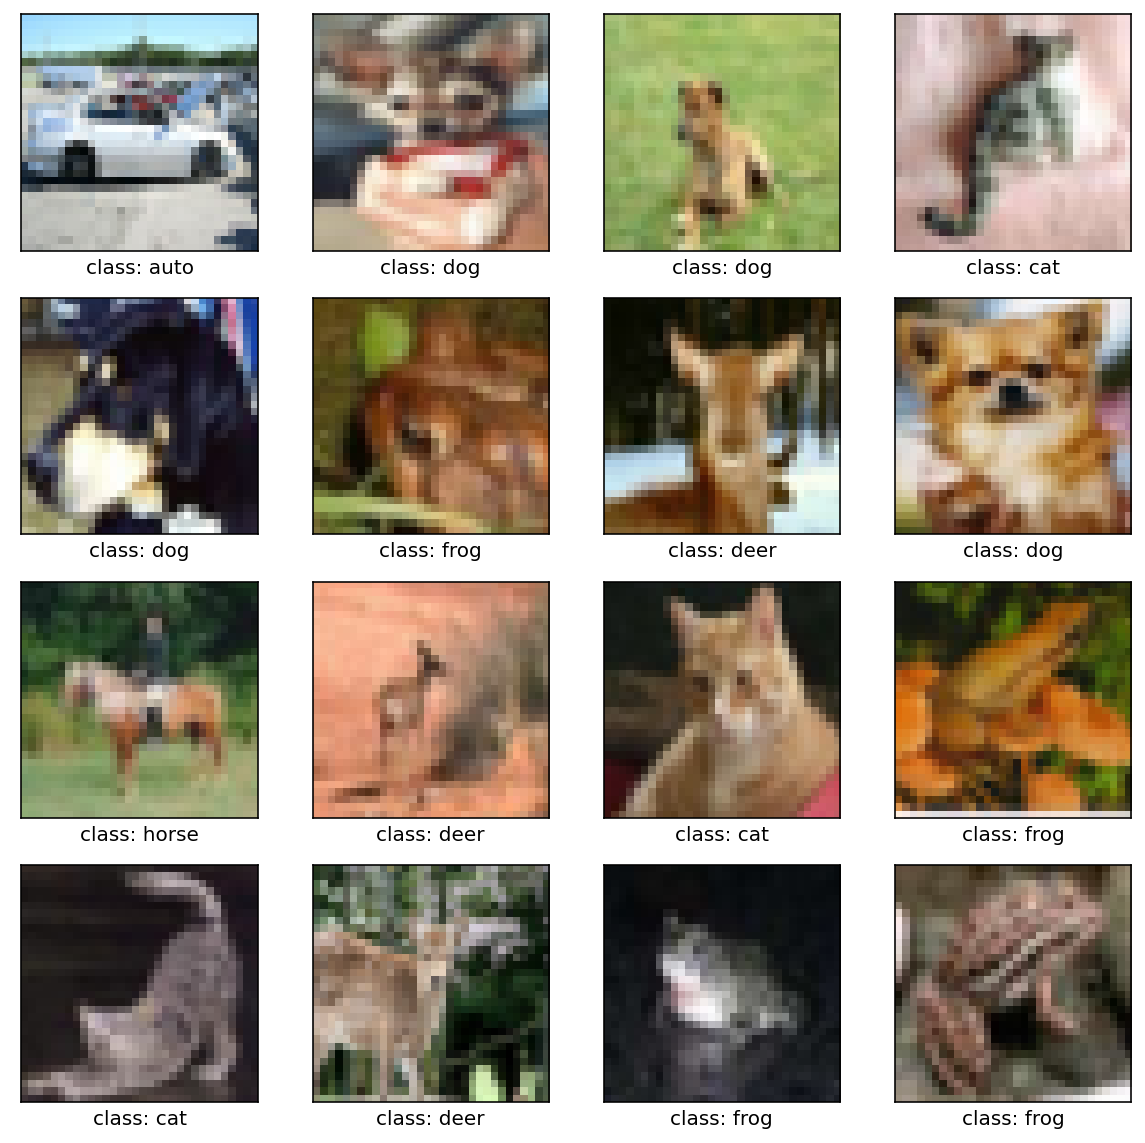

In [194]:
plot_random_images(train, 16)

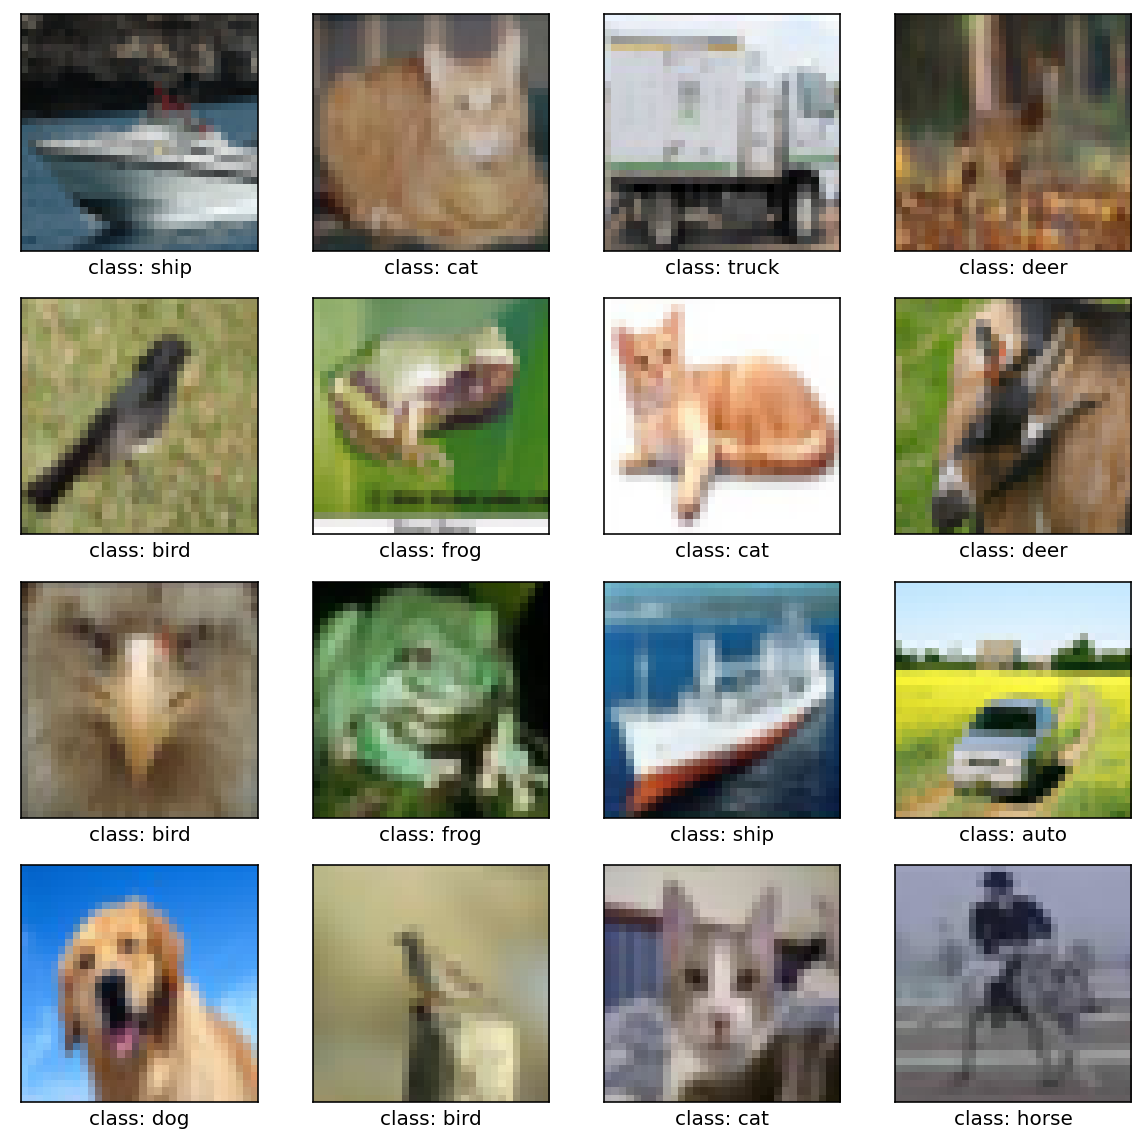

In [195]:
plot_random_images(test, 16)

## Usual preprocessing
as a part of usual preprocessing of data it is useful to substract the mean and normalize the data.
The data is already normalized, hence only the mean should be substracted.

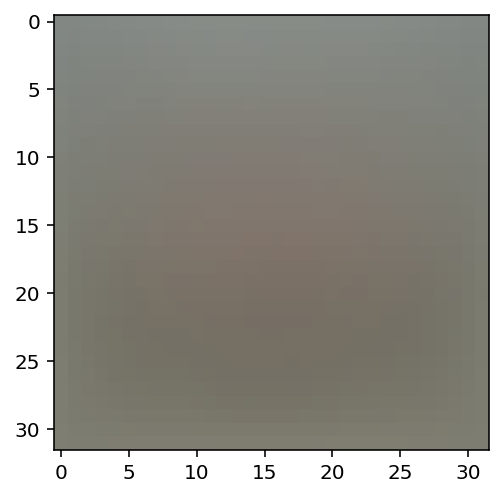

In [196]:
# here we visualize the mean
mean_image = np.mean(train['data'], axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

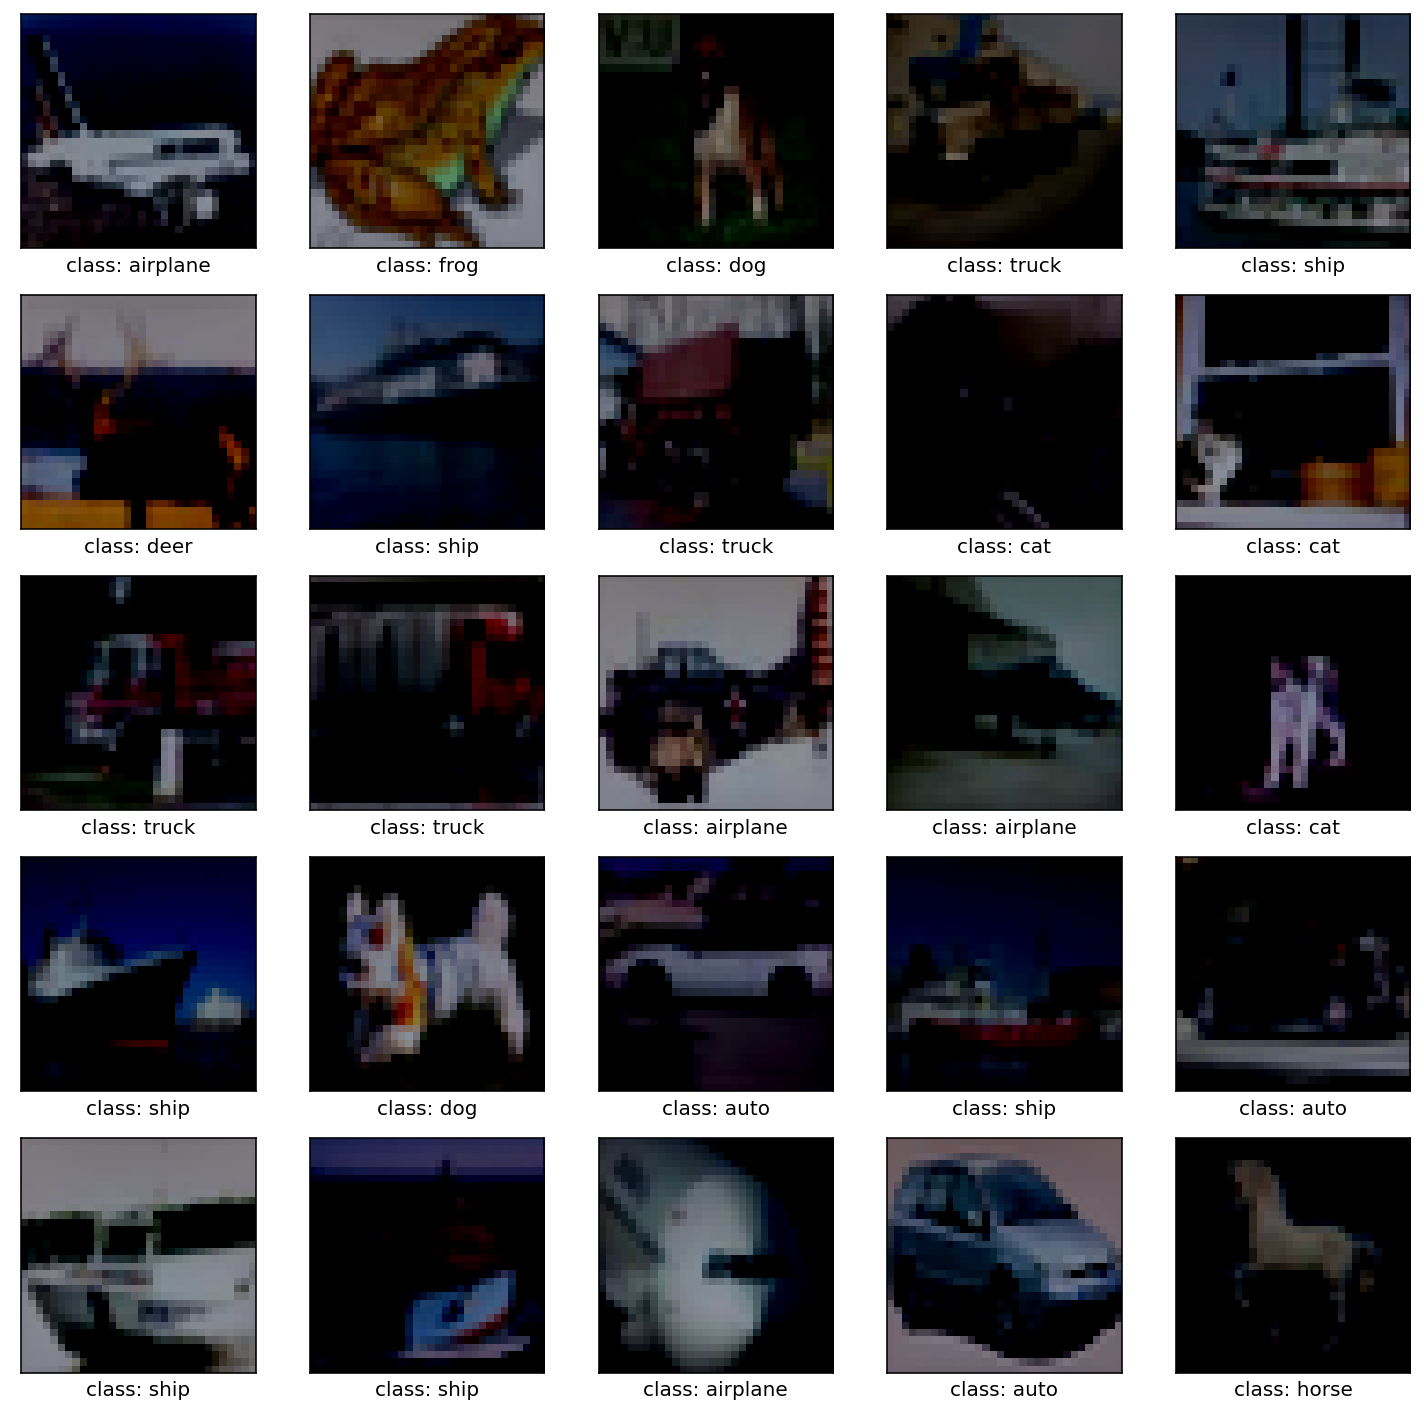

In [197]:
# ... and substract it from the data
train['data'] = train['data'] - mean_image
test['data'] = test['data'] - mean_image

# Visualize some samples of each category after preprocessing
plot_random_images(train, 25)

In [198]:
# now we flatten the data
x_train = train['data'].reshape(train['data'].shape[0], -1)
x_test  = test['data'].reshape(test['data'].shape[0], -1)

y_train = train['labels']
y_test  = test['labels']

## Bias vector trick
The bias vector $\vec b$ in <br>

<center>$\hat W \vec x + \vec b = \vec y$ </center>  <br>
can be incorporated in $\hat W$ by modifying the vector $\vec x$ <br>
<center> $\vec x ^\prime = (x_0,\, x_1,\, ..., x_{3072}, 1)$ </center>  <br>
hence
$$
\hat W ^\prime = \begin{pmatrix}
W_{1}^1 & ... & W_{3072}^1 & b^1\\
... & ... & ... & ... \\
W_{1}^10 & ... & W_{3072}^10 & b^{10}\\
\end{pmatrix}
$$
 and 
<center> $ \hat W^\prime \vec x^\prime = \vec y$ </center> 

In [199]:
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

print(x_train.shape, x_test.shape)

(54000, 3073) (6000, 3073)


## SVM Classifier

Now we implement the svm loss and gradient. It's implemented in file **SVM/linear_svm.py**

In [211]:
# Evaluate the naive implementation of the loss we provided for you:
from SVM.linear_SVM import LinearSVM
import time

model = LinearSVM()

In [212]:
tic = time.time()
loss_hist = model.train(x_train, y_train, n_epochs=500,
                             validate=True, x_val=x_test, y_val=y_test,
                             use_numpy=True, log_period=10)#, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized[0], toc - tic))

iteration 0 / 500: loss 8.990710
validation accuracy 0.19
iteration 10 / 500: loss 7.811425
validation accuracy 0.24
iteration 20 / 500: loss 7.368861
validation accuracy 0.26
iteration 30 / 500: loss 6.334578
validation accuracy 0.27
iteration 40 / 500: loss 6.048744
validation accuracy 0.27
iteration 50 / 500: loss 6.490905
validation accuracy 0.28
iteration 60 / 500: loss 6.165263
validation accuracy 0.28
iteration 70 / 500: loss 6.076342
validation accuracy 0.29
iteration 80 / 500: loss 5.567229
validation accuracy 0.30
iteration 90 / 500: loss 5.934961
validation accuracy 0.31
iteration 100 / 500: loss 6.152003
validation accuracy 0.31
iteration 110 / 500: loss 5.337172
validation accuracy 0.32
iteration 120 / 500: loss 5.636221
validation accuracy 0.32
iteration 130 / 500: loss 5.724436
validation accuracy 0.32
iteration 140 / 500: loss 5.176676
validation accuracy 0.32
iteration 150 / 500: loss 5.155989
validation accuracy 0.32
iteration 160 / 500: loss 5.620639
validation accur

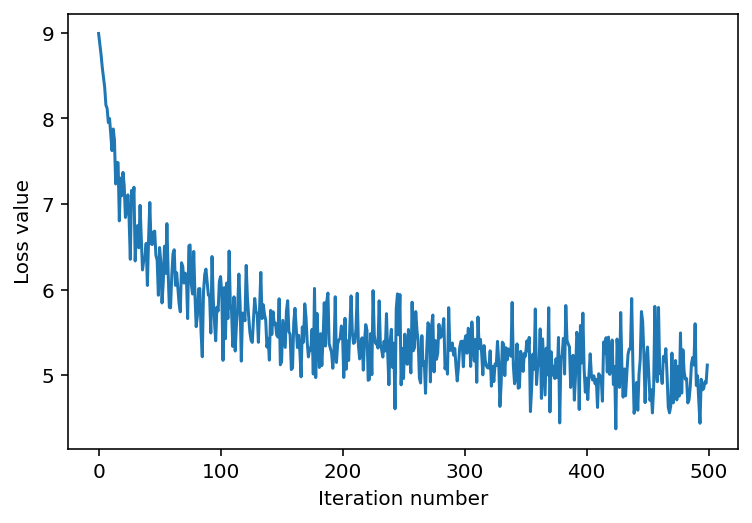

In [213]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()